# Classifiez automatiquement des biens de consommation
## Notebook 3 : Faisabilité de classification d'images via CNN
OpenClassrooms - Parcours Data Scientist - Projet 06  

## Présentation du projet

**Contexte**  


* **Place de marché** souhaite lancer une marketplace e-commerce anglophone  
* Les vendeurs proposent des articles à des acheteurs en postant une photo et une description  
* Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, elle est peu fiable. Le volume des articles est très petit  
* Il devient nécessaire d'**automatiser la tâche d‘attribution de la catégorie**

**Missions**  
* Étude de faisabilité à partir de données texte (Notebook 1)  
* Étude de faisabilité à partir des images - SIFT (Notebook 2)  
* **Étude de faisabilité à partir des images - CNN** (ce notebook)  
* Collecte de produits à partie d'une API (Notebook 4)

**Étude de faisabilité à partir des images via CNN**  
* **CNN** : **C**onvolutional **N**eural **N**etworks = Réseaux de Neurones Convolutifs
* Modèles :  
   * Modèle simple (4 couches de convolution), qui servira de base de référence  
   * VGG16 pour bénéficier du transfer learning  
   * VGG16 avec data augmentation

**Étapes**  
* Prétraitement commun des images  
* Pour chaque modèle :
    * Entraînement du modèle  
    * Récupération des features  
    * KMeans + t-SNE  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules  

**Préparation des données**  
* Chargement du dataset
* Création des labels
* Affichage des images par catégories
* Préparation du prétraitement
* Split des données entraînement / test

**CNN sans transfert Learning**  
* Entraînement du modèle  
* Feature extraction  
* Réduction de dimension et visualisation  

**CNN avec transfert Learning (VGG16)**  
* Entraînement du modèle  
* Feature extraction  
* Réduction de dimension et visualisation  

**CNN avec transfert Learning (VGG16) avec data augmentation**  
* Entraînement du modèle  
* Feature extraction  
* Réduction de dimension et visualisation  

**Conclusion sur la faisabilité**  
* Scores
* Exemples d'images mal classées

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc6_3


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('numpy')
install_package('pandas')
install_package('matplotlib')
install_package('seaborn')
install_package('tensorflow')
install_package('scikit-learn')
install_package('pillow')

numpy est déjà installé.
pandas est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
tensorflow est déjà installé.
scikit-learn est déjà installé.
pillow est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import time
import warnings
import shutil
import random

from PIL import Image

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

* Chargement du DataFrame de stockage des métriques

In [5]:
df_metrics = pd.read_csv('df_metrics.csv')

* Paramétrages

In [6]:
# FAST_MODE = False # Force l'exécution du code concerné, et écrase les fichiers s'ils existent
FAST_MODE = True

In [7]:
# Nombre de coeurs disponibles
print(os.cpu_count())

16


In [8]:
# Nombre de coeurs à utiliser
NUM_CORES = 8

# 2 Préparation des données

## 2.1 Chargement du dataset

In [9]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [10]:
# Affichage de quelques lignes avec les features clés
display(df_datas[['image', 'product_category_tree']].head(3))

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                               product_category_tree  
0  ["Home Furnishing >> Curtains & Accessories >>...  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...

## 2.2 Création des labels des images

* Création d'un DataFrame avec :
    * nom du fichier image (`image`)  
    * nom de la catégorie (`label_name`)

In [11]:
# Récupération des noms de catégories principales
df_datas['label_name'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

# Suppression des colonnes inutilisées
df_datas = df_datas[['image', 'label_name']]

# LabelEncoding des catégories
category_label_encoder = LabelEncoder()
labels = category_label_encoder.fit_transform(df_datas['label_name'])
categories = category_label_encoder.classes_

In [12]:
display(df_datas)

image       label_name
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing
...                                    ...              ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care

[1050 rows x 2 columns]

In [13]:
df_datas.groupby('label_name').count()

image
label_name                       
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

## 2.3 Affichage des images par catégories

In [14]:
# Répertoire où se trouvent les fichiers images
image_path = './images/'

Catégorie : Home Furnishing


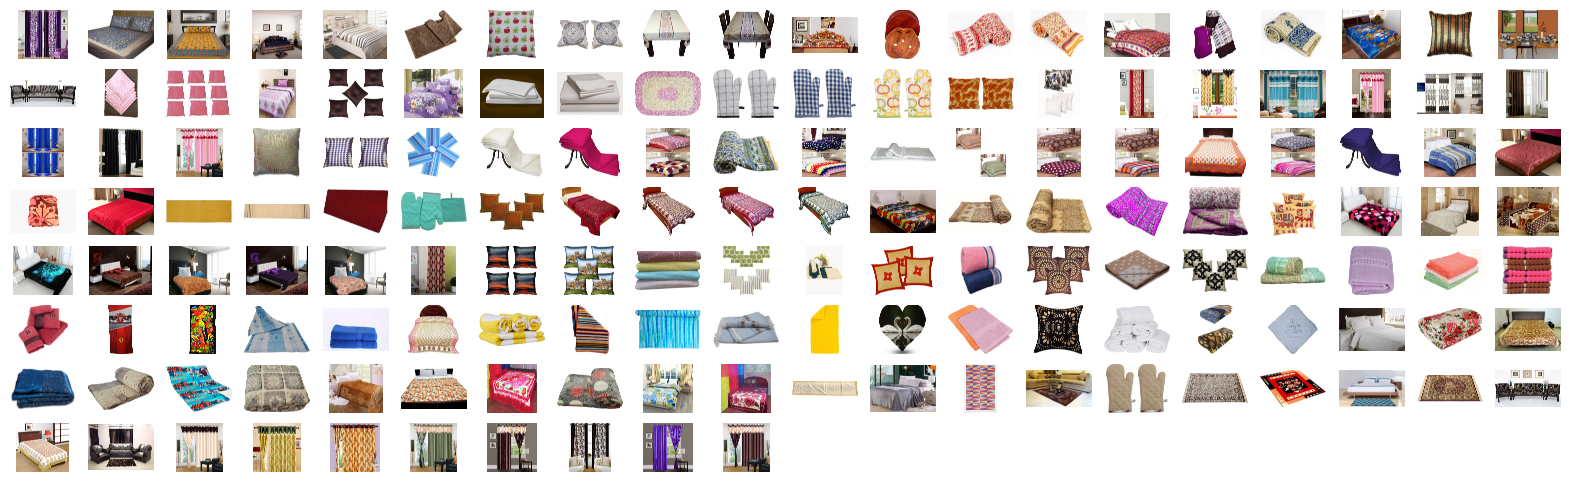


Catégorie : Baby Care


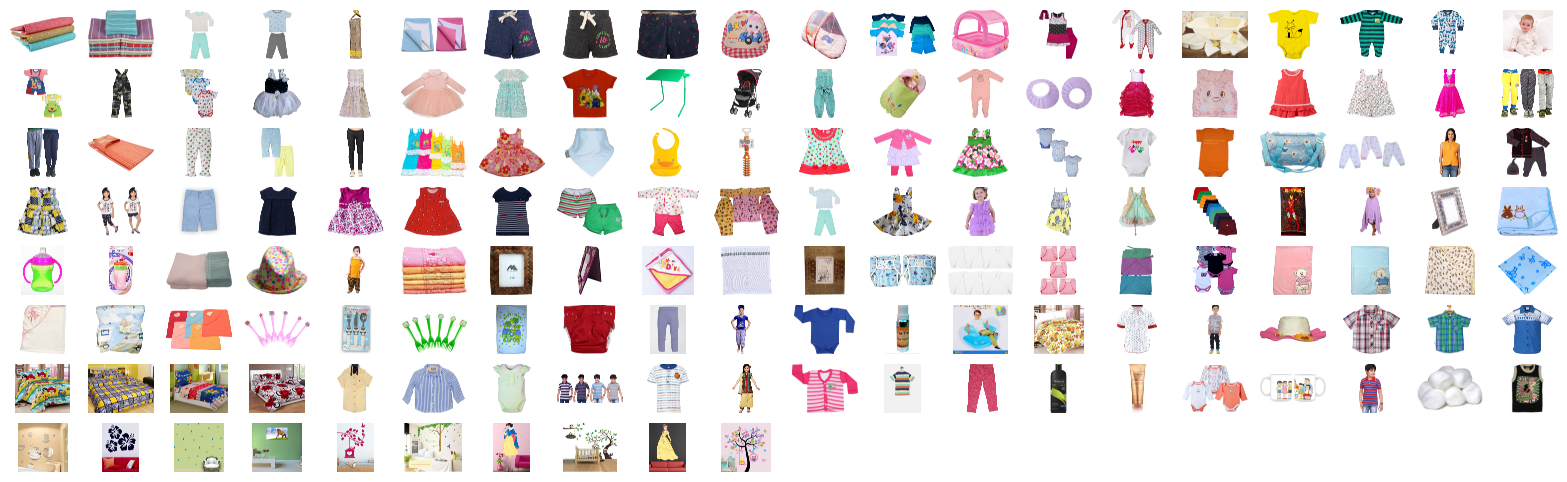


Catégorie : Watches


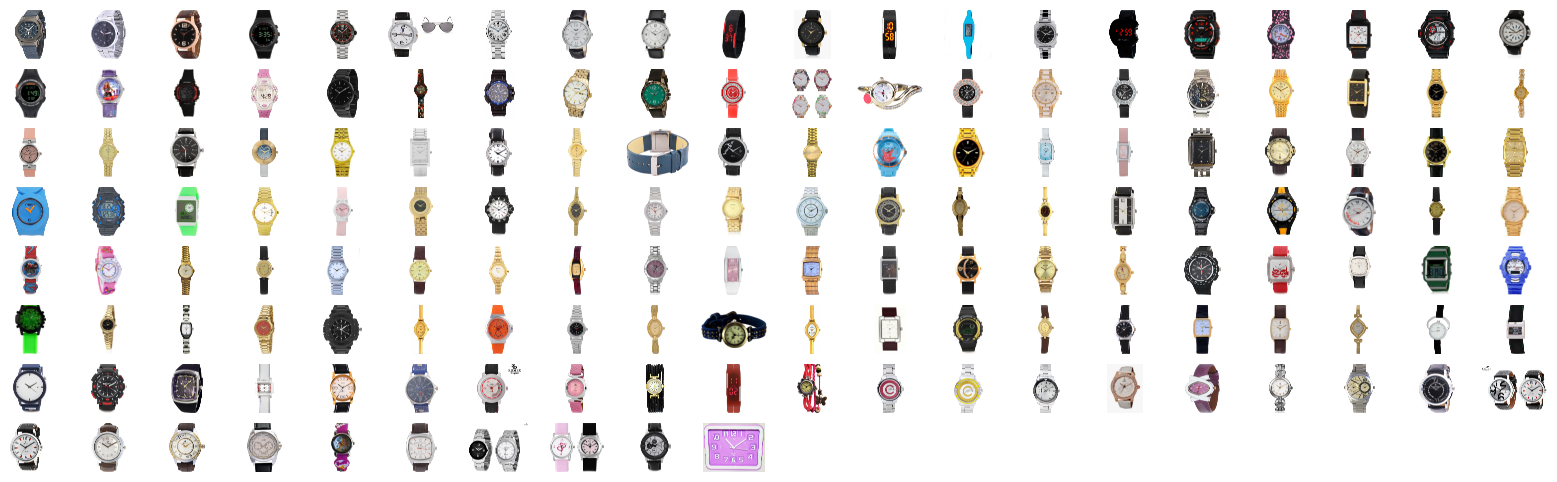


Catégorie : Home Decor & Festive Needs


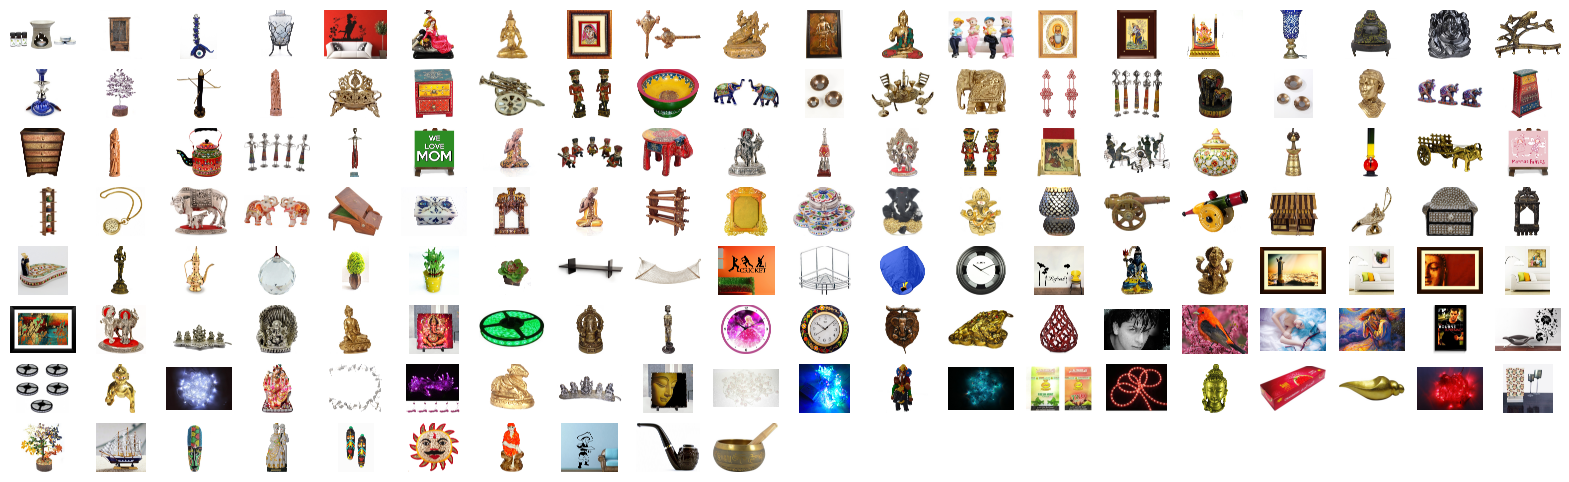


Catégorie : Kitchen & Dining


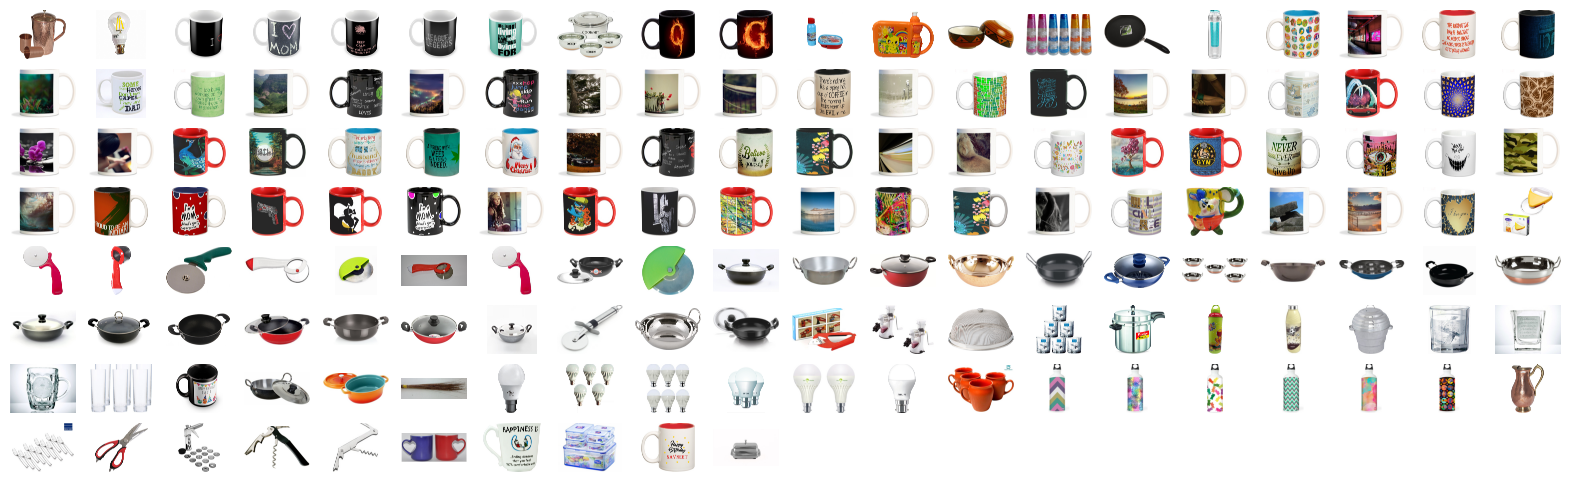


Catégorie : Beauty and Personal Care


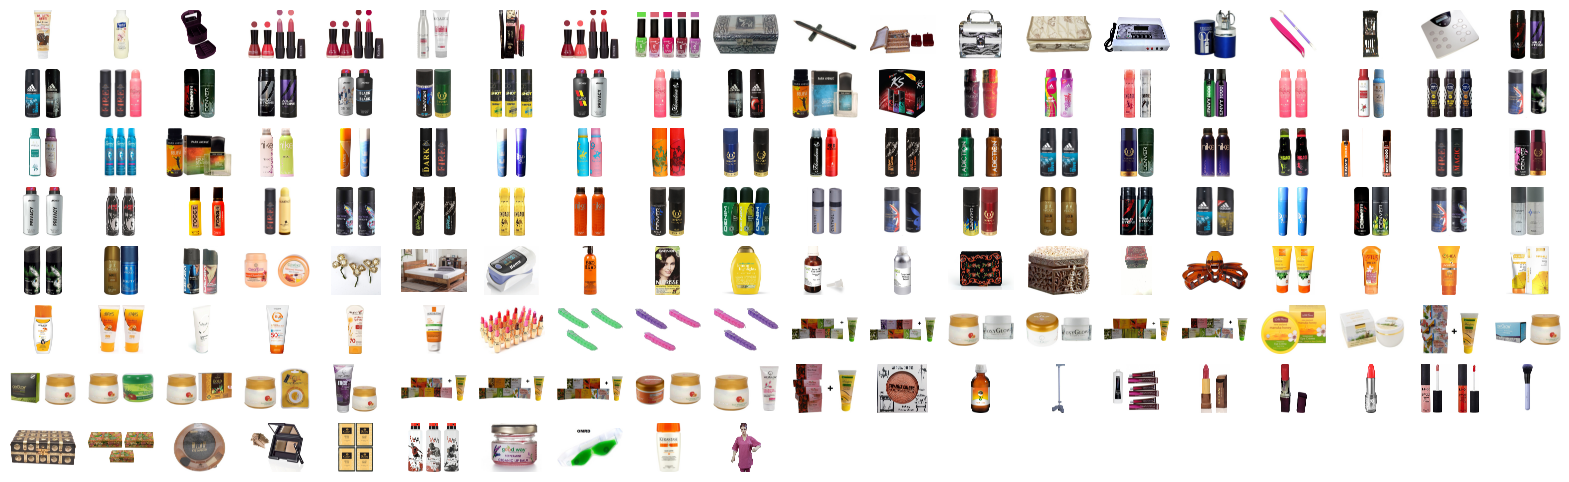


Catégorie : Computers


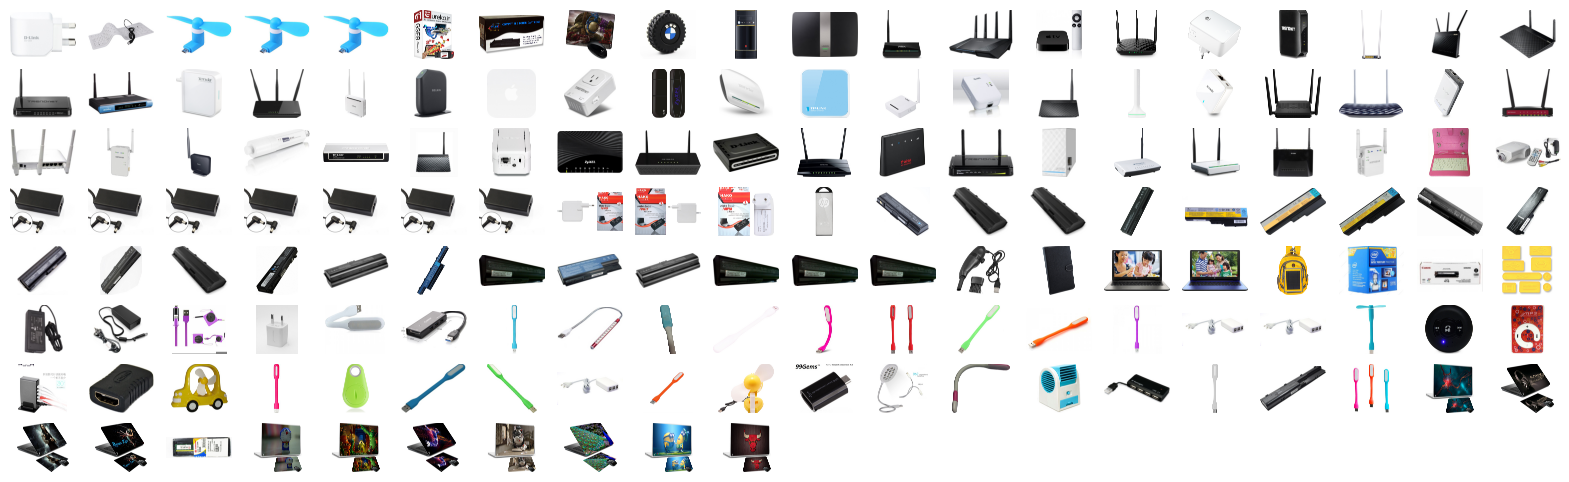

In [15]:
# Suppression de la limite de taille des images
Image.MAX_IMAGE_PIXELS = None

# Affichage des 150 images de chaque catégorie
for category in df_datas['label_name'].unique():
    mask = df_datas['label_name'] == category
    images = df_datas.loc[mask, 'image'].values
    print(f"Catégorie : {category}")
    plt.figure(figsize=(20, 6))
    for i in range(150):
        plt.subplot(8, 20, i + 1)
        filename = image_path + images[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print()

## 2.4 Préparation du prétraitement des images

Pour obtenir des résultats comparables, le choix est fait de s'aligner sur les prétraitements demandés pas le modèle VGG16, à savoir :  
* Images au format BGR  
* Images de taille 224 x 224  
* Normalisation consistant à soustraire à chaque pixel la valeur RVB moyenne des données d’entraînement  

* Si les 2 premières opérations sont réalisables simplement, la normalisation nécessiterait de disposer des données d'entrainement (le modèle VGG16 a été entraîné sur ImageNet, une base de données de plus de 14 millions d’images)
* Il est cependant possible d'utiliser la fonction `preprocess_input` de Keras pour réaliser ce prétraitement

* Fonction de prétraitement

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_images(df, image_path):
    """
    Prétraite les images pour alimenter les modèles CNN en les convertisant
    au format RGB, les redimensionnant en 224x224 pixels, en normalisant la
    valeur des pixels et en les stockant dans un array numpy.

    Parameters:
        df (pd.DataFrame): DataFrame contenant les variables 'image' (nom 
                           des fichiers image) et 'label'.
        image_path (str):  Répertoire contenant les fichiers image.

    Returns:
        tuple: Tuple contenant 2 arrays numpy :
            - images (np.ndarray): Array des images prétraitées, de dimensions (n_samples, 224, 224, 3).
            - labels (np.ndarray): Array des labels correpondants.
    """
    images = []
    labels = df['label_name'].values

    for img_name in df['image']:
        img_path = os.path.join(image_path, img_name)

        # Chargement et redimensionnement en 224x224
        img = load_img(img_path, target_size=(224, 224))

        # Conversion en array aux bonnes dimensions
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Preprocess VGG16
        img = preprocess_input(img)

        images.append(img)

    # Converversion des listes en arrays numpy
    images = np.array(images)

    return images, labels

## 2.5 Split des données en ensembles d'entraînement et de test

* 2 jeux de données seront préparés :  
   * Un ensemble pour l'entraînement de 80 % du dataset de base -> 840 produits, répartis en 120 produits par catégorie  
   * Un ensemble de test de 20 % du dataset de base -> 210 produits, répartis en 30 produits par catégorie  

* L'observation des images par catégorie montre des regroupements (tous les mugs sont ensemble, tous les routeurs wifi aussi...) : pour que les jeux de données soient mieux équilibrés il sera nécessaire de **mélanger les produits** dans les catégories avant le split

### 2.5.1 Splits après shuffle des données

In [17]:
# DataFrames vides
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [18]:
# Train / test
for category in df_datas['label_name'].unique():
    category_images = df_datas[df_datas['label_name'] == category]
    images = category_images['image'].tolist()
    # Shuffle des images
    random.shuffle(images)

    # Répartition des images mélangées
    train_images = images[:120]
    test_images = images[120:]

    for i, image in enumerate(images):
        if i < 120:
            df_train = pd.concat([df_train, df_datas[df_datas['image'] == image]])
        else:
            df_test = pd.concat([df_test, df_datas[df_datas['image'] == image]])

### 2.5.2 Vérification visuelle

df_train Kitchen & Dining (120 produits):


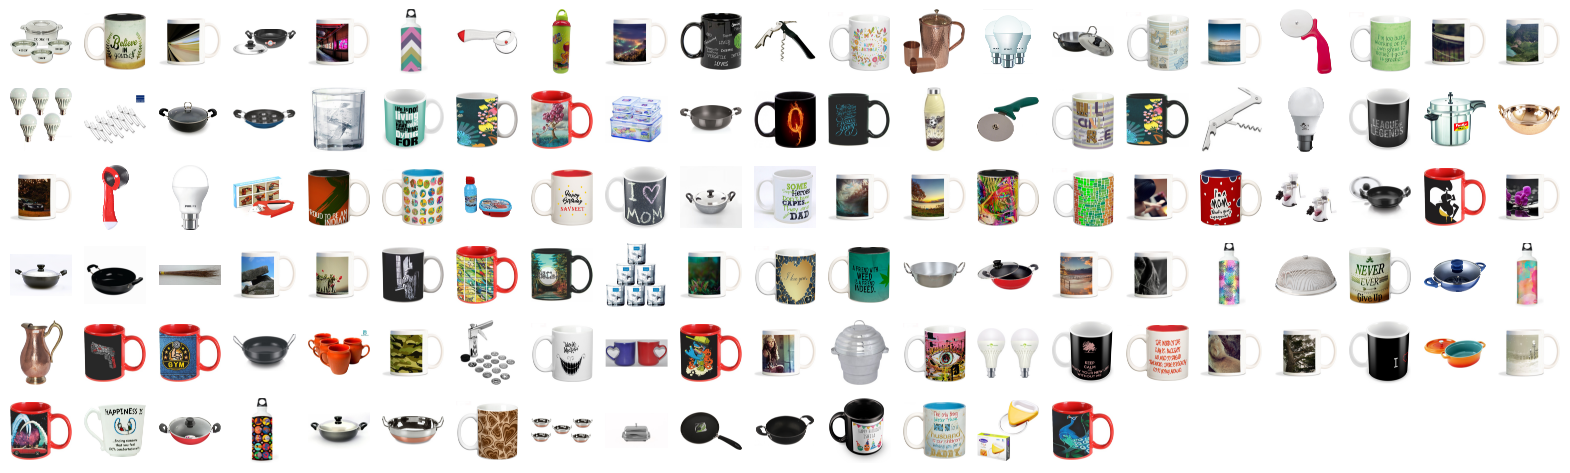


df_test Kitchen & Dining (30 produits):


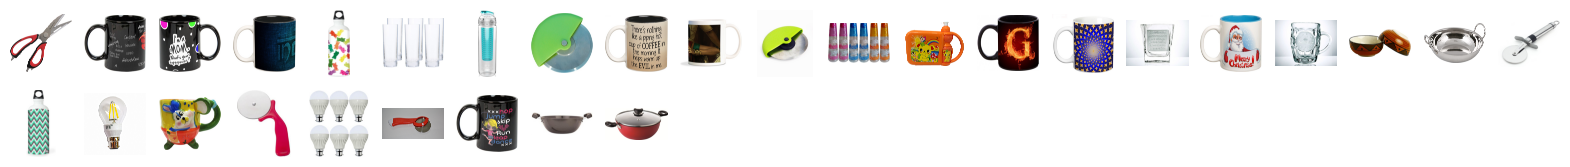

In [19]:
# Affichage des images de la catégorie 'Kitchen & Dining' pour chaque ensemble de données
for df, df_name in zip([df_train, df_test], ['df_train', 'df_test']):
    mask = df['label_name'] == 'Kitchen & Dining'
    images = df.loc[mask, 'image'].values
    num_img = len(images)
    print(f"{df_name} Kitchen & Dining ({num_img} produits):")
    plt.figure(figsize=(20, num_img // 7))
    for i in range(num_img):
        plt.subplot(num_img // 7, 21, i + 1)
        filename = image_path + images[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print()

### 2.5.3 Vérification des répartitions par catégories

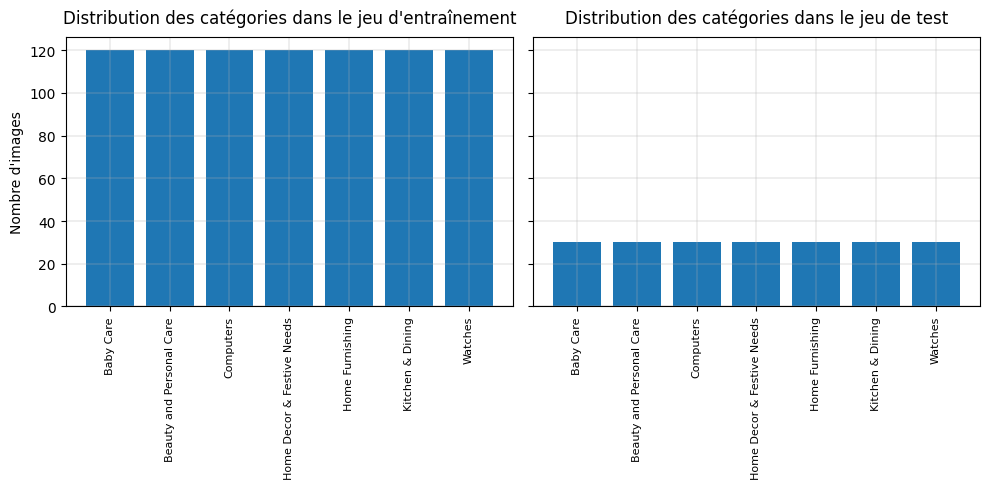

In [20]:
# Distribution des catégorie pour chaque ensemble de données
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
i = 0
for df, set_name, ax in zip([df_train, df_test], 
                            ['jeu d\'entraînement', 'jeu de test'], 
                            axes):
    df_counts = df.groupby('label_name').count().reset_index()
    ax.bar(df_counts['label_name'], df_counts['image'])
    ax.set_title(f"Distribution des catégories dans le {set_name}", fontsize=12, pad=10)
    ax.set_xticks(df_counts['label_name'])
    ax.set_xticklabels(df_counts['label_name'], fontsize=8, rotation=90)
    ax.grid(linewidth=0.3)
    if i == 0: ax.set_ylabel("Nombre d'images")
    i += 1

plt.tight_layout()
plt.show()

## 2.6 Application du prétraitement

In [21]:
# Application du prétraitement aux données splitées
imag_path = './images'

df_train_images, df_train_labels = preprocess_images(df_train, image_path)
df_test_images, df_test_labels = preprocess_images(df_test, image_path)

In [22]:
# Encodage des labels
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
df_train_labels = lb.fit_transform(df_train_labels)
df_test_labels = lb.transform(df_test_labels)

In [23]:
df_train_labels.shape

(840, 7)

In [24]:
# Afficher les dimensions après le prétraitement
print("Forme de l'ensemble d'entraînement (images) :", df_train_images.shape)
print("Forme de l'ensemble de test (images) :", df_test_images.shape)
print("Forme de l'ensemble d'entraînement (étiquettes) :", df_train_labels.shape)
print("Forme de l'ensemble de test (étiquettes) :", df_test_labels.shape)

Forme de l'ensemble d'entraînement (images) : (840, 224, 224, 3)
Forme de l'ensemble de test (images) : (210, 224, 224, 3)
Forme de l'ensemble d'entraînement (étiquettes) : (840, 7)
Forme de l'ensemble de test (étiquettes) : (210, 7)


# 3 CNN (Réseau de neurones convolutif, sans transfer learning)

## 3.1 Entraînement du modèle

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

In [26]:
epochs = 10
batch_size = 32

# Création du modèle CNN
model_cnn = Sequential()

# Input
model_cnn.add(Input(shape=(224, 224, 3)))

# Ajout des couches convolutives
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

# Ajout des couches entièrement connectées
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

# Compilation du modèle
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Enregistrement du temps de début
start_time = time.perf_counter()

# history_cnn = model_cnn.fit(df_train_images, df_train_labels, epochs=15, validation_split=0.2, callbacks=[early_stopping])
history_cnn = model_cnn.fit(df_train_images, df_train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)

# Enregistrement du temps de fin
end_time = time.perf_counter()

# Calculer et afficher le temps écoulé
cnn_fit_duration = end_time - start_time
print(f"Durée d'entrainement avec {epochs} epochs : {cnn_fit_duration:.2f} secondes.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,807 (5.65 MB)

 Trainable params: 1,480,807 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.1925 - loss: 24.5992 - val_accuracy: 0.0595 - val_loss: 1.9631
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1901 - loss: 1.9311 - val_accuracy: 0.0000e+00 - val_loss: 2.0128
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1667 - loss: 1.9220 - val_accuracy: 0.0060 - val_loss: 2.0754
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2097 - loss: 1.8927 - val_accuracy: 0.0000e+00 - val_loss: 2.5749
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2148 - loss: 1.8500 - val_accuracy: 0.0000e+00 - val_loss: 2.1805
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2019 - loss: 1.8787 - val_accuracy: 0.0179 - val_loss: 2.3663
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2389 - loss: 1.8126 - val_accuracy: 0.0655 - val_loss: 2.5114
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3437 - loss: 1.6222 - val_accuracy: 0.041

In [27]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.3672 - loss: 2.4861


Précision sur les données de test : 34.29%


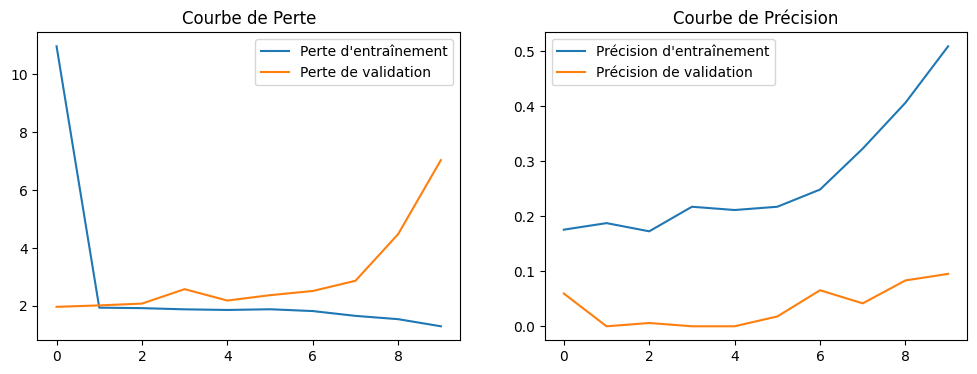

In [28]:
# Précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

## 3.2 Feature extraction

* Fonction

In [29]:
def features_extraction(images, model):
    """
    Récupère les features des images par prédiction.

    Parameters:
        images (array-like): Liste des noms de fichiers images
        model (keras.src.models.sequential.Sequential): Modèle préentraîné à utiliser

    Returns:
        images_features (array Numpy): Liste des features
        fe_duration: Durée en secondes de la feature extraction
    """
    start_fe = time.perf_counter()
    
    images_features = []
    image_path = './images/'
    
    for img_name in images:
        img_path = os.path.join(image_path, img_name)
    
        # Chargement et redimensionnement en 224x224
        img = load_img(img_path, target_size=(224, 224))
    
        # Conversion en array aux bonnes dimensions
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
    
        # Preprocess VGG16
        img = preprocess_input(img)

        # Récupération des features par prédiction
        images_features.append(model.predict(img, verbose=0)[0])
    
    images_features = np.asarray(images_features)
    
    end_fe = time.perf_counter()
    fe_duration = end_fe - start_fe

    return images_features, fe_duration

* Récupération

In [30]:
# Récupération des features
cnn_images_features, fe_duration = features_extraction(df_datas['image'], model_cnn)

print(f"Durée d'extraction : {fe_duration:.2f} secondes")
print(f"Nombre d'images traitées : {cnn_images_features.shape[0]}")
print(f"Nombre de features par image : {cnn_images_features.shape[1]}")

Durée d'extraction : 75.24 secondes
Nombre d'images traitées : 1050
Nombre de features par image : 7


In [31]:
# Conversion en DataFrame et ajout des labels
df_cnn = pd.DataFrame(cnn_images_features)
df_cnn['label'] = labels

## 3.3 Réduction de dimension et visualisation

* Fonctions

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [33]:
def plot_categories_and_kmeans_clusters_after_reduction(datas, target):
    
    # Réductions de dimension
    X = datas.drop(target, axis=1)
    # PCA
    pca = PCA(n_components=0.99, random_state=0)
    pca_components = pca.fit_transform(X)
    # t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    components = tsne.fit_transform(pca_components)
    
    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=7, random_state=0)
    kmeans_labels = kmeans.fit_predict(components)
    
    # Préparation des données pour la visualisation
    df_vis = pd.DataFrame(components, columns=['tsne 1', 'tsne 2'])
    df_vis[target] = datas[target]
    df_vis['Cluster'] = kmeans_labels
    df_vis['Catégorie'] = df_datas['label_name']

    # Génération des scatterplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    for i, criteria in enumerate(('Catégorie', 'Cluster')):
        sns.scatterplot(data=df_vis, x='tsne 1', y='tsne 2', hue=criteria, palette='bright', alpha=0.6, ax=ax[i])
        ax[i].set_title(f"{criteria}s - TSNE", fontweight='bold', pad=10)
        ax[i].set_xlabel('tsne 1', fontweight = 'bold')
        ax[i].set_ylabel('tsne 2', fontweight = 'bold')
        ax[i].legend(prop={'size': 8})
    
    plt.show()

    return kmeans_labels

In [34]:
def ari_score(true_labels, predicted_labels):
    # Calcul de l'Adjusted Rand Index
    ari_score = adjusted_rand_score(true_labels, predicted_labels)
    
    return ari_score

In [35]:
def compare_real_categories_vs_kmeans_clusters(model_name, datas, target, preprocessing_duration, feature_extraction_duration):
    global df_metrics
    kmeans_labels = plot_categories_and_kmeans_clusters_after_reduction(datas, target)
    score = ari_score(datas[target], kmeans_labels)
    new_row = pd.DataFrame({
        'Modèle': [model_name],
        'Méthode de réduction de dimensions': ['t-SNE'],
        'Score ARI': [score],
        'Durée totale': [f"{np.round(preprocessing_duration + feature_extraction_duration, 2)} secs"],
        'Durée de prétraitement': [f"{np.round(preprocessing_duration, 2)} secs"],
        'Durée d\'extraction des features': [f"{np.round(feature_extraction_duration, 2)} secs"]
    })
    df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)
    df_metrics['Accuracy'] = df_metrics['Accuracy'].fillna('-')
    print(f"Adjusted Rand Index: {score}")

    return kmeans_labels

* Visualisation

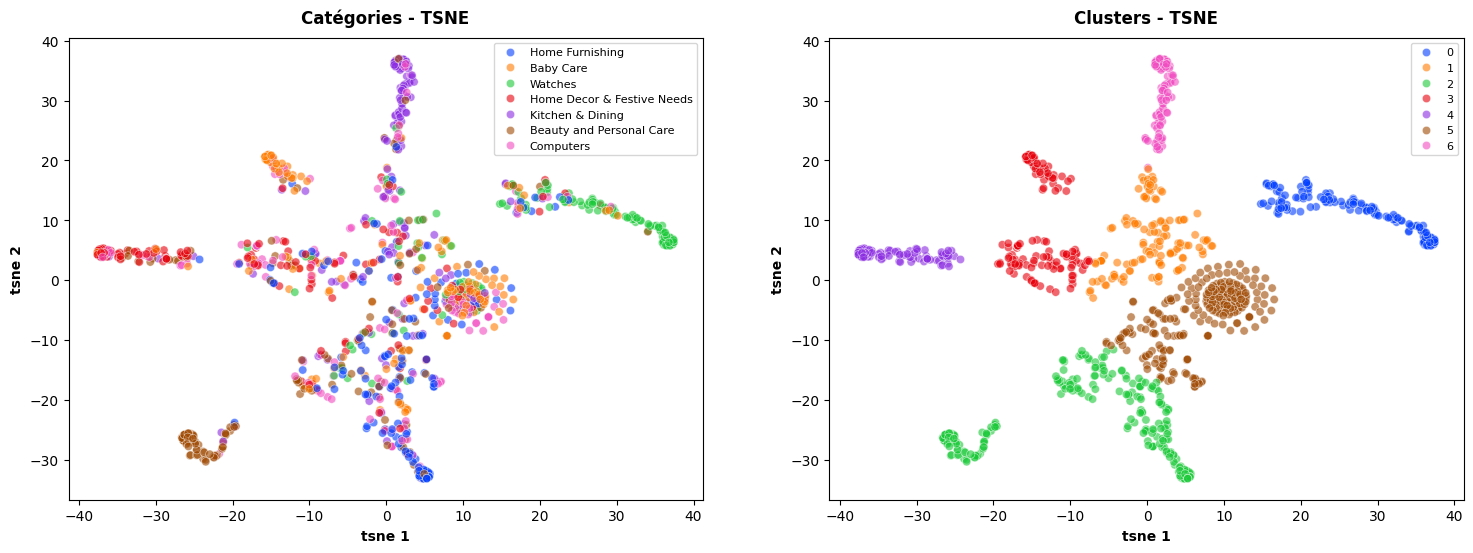

Adjusted Rand Index: 0.1542163547829233


In [36]:
cnn_labels = compare_real_categories_vs_kmeans_clusters('CNN', df_cnn, 'label', fe_duration, cnn_fit_duration)

# 4 CNN Transfer Learning (VGG16)

## 4.1 Entraînement du modèle

In [37]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [38]:
model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Layers non entraînables (conservation des poids du modèle pré-entraîné)
for layer in model.layers:
    layer.trainable = False

# Récupération de la sortie
x = model.output

# Complétion du modèle
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Définition du nouveau modèle
vgg16_model = Model(inputs=model.input, outputs=predictions)
# compilation du modèle 
vgg16_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

vgg16_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,975 (56.26 MB)

 Trainable params: 33,287 (130.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
epochs = 10
batch_size = 32

start_time = time.perf_counter()

# Entraînement du modèle
history_vgg16 = vgg16_model.fit(df_train_images, df_train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)

vgg16_fit_duration = time.perf_counter() - start_time

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.1612 - loss: 12.5249 - val_accuracy: 0.2500 - val_loss: 4.8860
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4768 - loss: 2.0956 - val_accuracy: 0.2202 - val_loss: 4.4652
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5853 - loss: 1.3188 - val_accuracy: 0.2321 - val_loss: 3.8179
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6615 - loss: 0.9851 - val_accuracy: 0.2262 - val_loss: 3.9790
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6810 - loss: 0.8712 - val_accuracy: 0.2262 - val_loss: 4.2674
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6931 - loss: 0.7904 - val_accuracy: 0.2321 - val_loss: 4.0379
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7727 - loss: 0.6609 - val_accuracy: 0.2381 - val_loss: 4.0299
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7761 - loss: 0.6324 - val_accuracy: 0.2440 - val_loss

In [40]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = vgg16_model.evaluate(df_test_images, df_test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7350 - loss: 1.0298


Précision sur les données de test : 65.71%


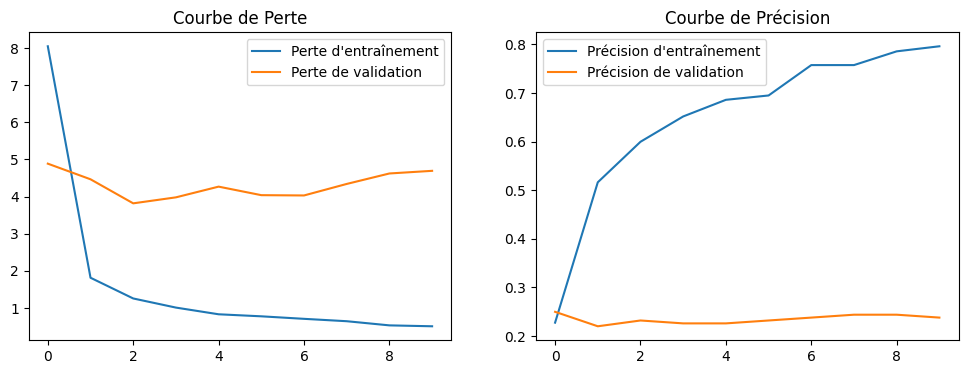

In [41]:
# Précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Perte d\'entraînement')
plt.plot(history_vgg16.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_vgg16.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

## 4.2 Feature extraction

In [42]:
# Récupération des features
vgg16_images_features, vgg16_fe_duration = features_extraction(df_datas['image'], vgg16_model)

print(f"Durée d'extraction : {vgg16_fe_duration:.2f} secondes")
print(f"Nombre d'images traitées : {vgg16_images_features.shape[0]}")
print(f"Nombre de features par image : {vgg16_images_features.shape[1]}")

Durée d'extraction : 213.61 secondes
Nombre d'images traitées : 1050
Nombre de features par image : 7


In [43]:
# Conversion en DataFrame et ajout des labels
df_vgg16 = pd.DataFrame(vgg16_images_features)
df_vgg16['label'] = labels

## 4.3 Réduction de dimension et visualisation

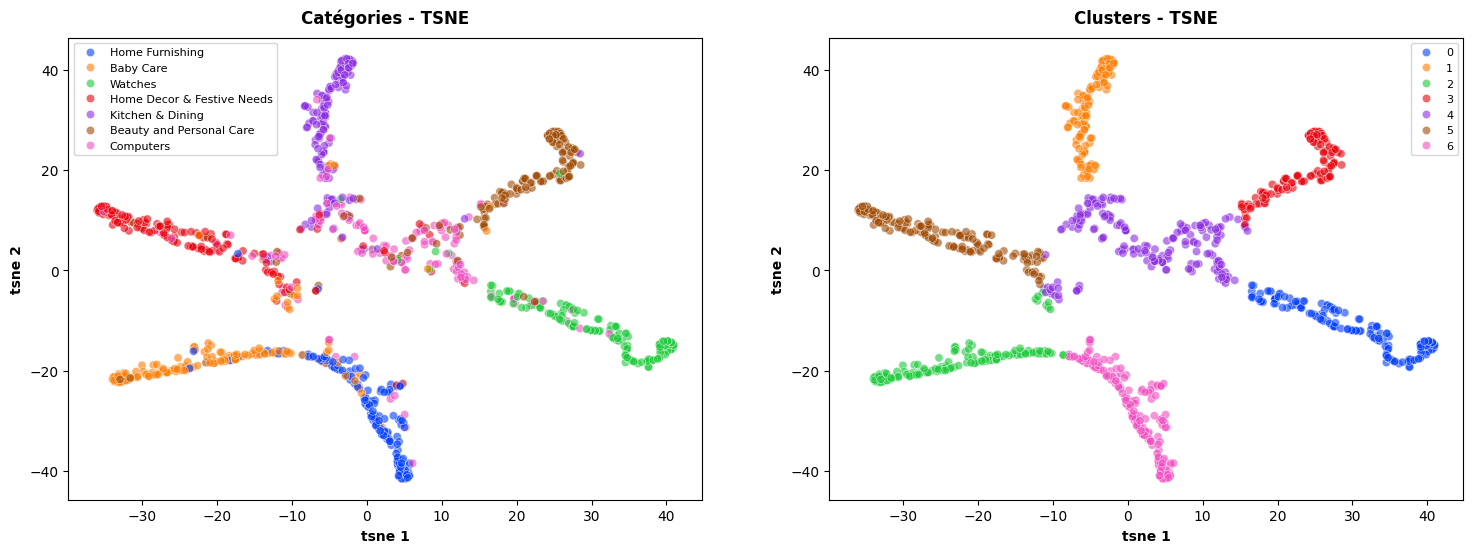

Adjusted Rand Index: 0.6346701938388916


In [44]:
vgg16_labels = compare_real_categories_vs_kmeans_clusters('VGG16', df_vgg16, 'label', vgg16_fe_duration, vgg16_fit_duration)

# 5 CNN Transfer Learning (VGG16) avec Data augmentation

## 5.1 Entraînement du modèle

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [46]:
epochs = 10
batch_size = 32

start_time = time.perf_counter()

# Fit du modèle précédent avec Data augmentation sur les données en input
history_vgg16_da = vgg16_model.fit(
    datagen.flow(df_train_images, df_train_labels, batch_size=batch_size),
    epochs=epochs,
    validation_data=(df_test_images, df_test_labels)
)

vgg16_da_fit_duration = time.perf_counter() - start_time

Epoch 1/10


C:\Users\chrab\anaconda3\envs\opc6_3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5926 - loss: 1.3370 - val_accuracy: 0.6762 - val_loss: 1.1149
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6185 - loss: 1.0258 - val_accuracy: 0.7286 - val_loss: 0.9739
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6691 - loss: 0.8911 - val_accuracy: 0.7476 - val_loss: 0.9483
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6967 - loss: 0.7988 - val_accuracy: 0.7476 - val_loss: 0.8991
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7357 - loss: 0.7394 - val_accuracy: 0.7810 - val_loss: 0.8675
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7229 - loss: 0.7631 - val_accuracy: 0.7667 - val_loss: 0.8530
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7365 - loss: 0.6936 - val_accuracy: 0.7810 - val_loss: 0.8249
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7677 - loss: 0.6598 - val_accuracy: 0.7905 - val_loss: 0.7925
Epo

In [47]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = vgg16_model.evaluate(datagen.flow(df_test_images, df_test_labels, batch_size=batch_size))

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8109 - loss: 0.6704


Précision sur les données de test : 80.00%


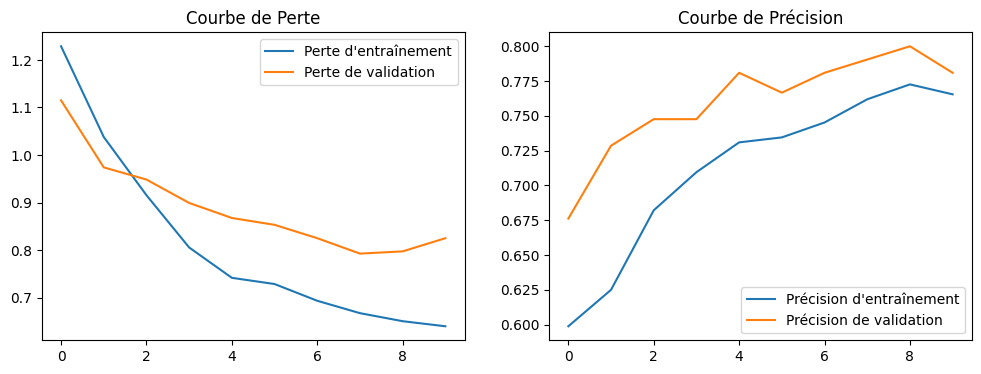

In [48]:
# Précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_da.history['loss'], label='Perte d\'entraînement')
plt.plot(history_vgg16_da.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_da.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_vgg16_da.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

## 5.2 Feature extraction

In [49]:
# Récupération des features
vgg16_da_images_features, vgg16_da_fe_duration = features_extraction(df_datas['image'], vgg16_model)

print(f"Durée d'extraction : {vgg16_da_fe_duration:.2f} secondes")
print(f"Nombre d'images traitées : {vgg16_da_images_features.shape[0]}")
print(f"Nombre de features par image : {vgg16_da_images_features.shape[1]}")

Durée d'extraction : 219.98 secondes
Nombre d'images traitées : 1050
Nombre de features par image : 7


In [50]:
# Conversion en DataFrame et ajout des labels
df_vgg16_da = pd.DataFrame(vgg16_da_images_features)
df_vgg16_da['label'] = labels

## 5.3 Réduction de dimension et visualisation

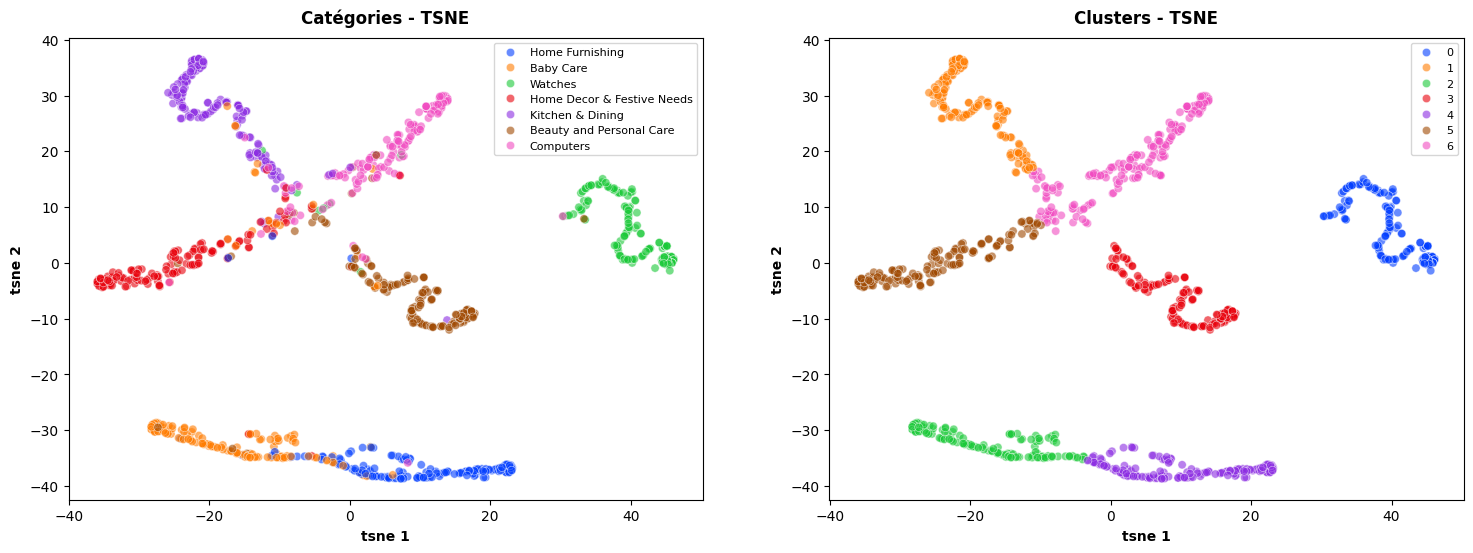

Adjusted Rand Index: 0.7595333612924675


In [51]:
vgg16_da_labels = compare_real_categories_vs_kmeans_clusters('VGG16 - Data augmentation', df_vgg16_da, 'label', vgg16_da_fe_duration, vgg16_da_fit_duration)

In [52]:
display(df_metrics.sort_values('Score ARI', ascending=False))

Modèle Méthode de réduction de dimensions  Score ARI  \
8  VGG16 - Data augmentation                              t-SNE   0.759533   
3                      SBERT                              t-SNE   0.711909   
7                      VGG16                              t-SNE   0.634670   
1                     Tf-idf                              t-SNE   0.486194   
4                        USE                              t-SNE   0.407112   
0            CountVectorizer                              t-SNE   0.396015   
2                   Word2Vec                              t-SNE   0.365215   
6                        CNN                              t-SNE   0.154216   
5                       SIFT                              t-SNE   0.053831   

  Durée totale Durée de prétraitement Durée d'extraction des features Accuracy  
8   752.3 secs            219.98 secs                     532.32 secs        -  
3   87.08 secs               0.0 secs                      87.08 secs     0.86  
7  624.69 secs            213.61 secs                     411.09 secs        -  
1    5.88 secs              5.84 secs                       0.04 secs        -  
4    4.97 secs               0.0 secs                       4.97 secs        -  
0    5.94 secs              5.84 secs                        0.1 secs        -  
2    5.92 secs              5.84 secs                       0.08 secs        -  
6  377.35 secs             75.24 secs                     302.11 secs        -  
5   65.14 secs             61.89 secs                       3.25 secs        -

# 6 Faisabilité à partir des données images

## 6.1 Scores

* Préparation matrice de confusion modèle VGG16 avec Data augmentation

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [54]:
def confusion_matrix_transform(y_true, y_pred) :
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    corresp = np.argmax(conf_matrix, axis=0)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [55]:
conf_matrix = confusion_matrix(labels, vgg16_da_labels)

In [56]:
vgg16_da_labels_transform = confusion_matrix_transform(labels, vgg16_da_labels)
conf_mat = confusion_matrix(labels, vgg16_da_labels_transform)

In [57]:
df_conf_matrix = pd.DataFrame(
    conf_mat,
    index = [label for label in categories],
    columns = [i for i in "0123456"]
)

**La faisabilité d'une classification automatique des produits à partir de leurs images est validée**

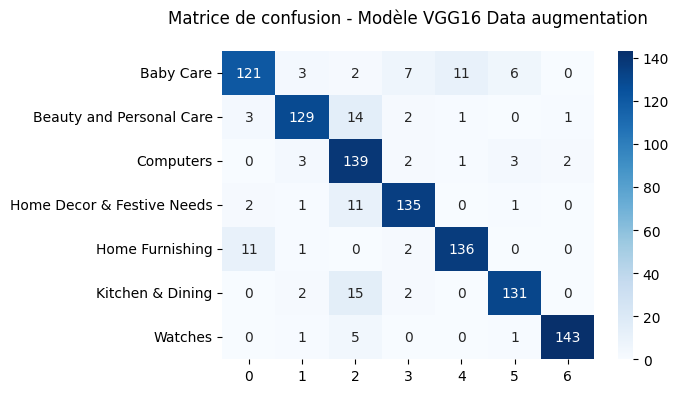

In [58]:
# Affichage matrice de confusion
plt.figure(figsize = (6, 4))
plt.title("Matrice de confusion - Modèle VGG16 Data augmentation", pad=20)
sns.heatmap(df_conf_matrix, annot=True, cmap="Blues", fmt='d')
plt.show()

* Rapport de classification

In [59]:
print(classification_report(labels, vgg16_da_labels_transform))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       150
           1       0.92      0.86      0.89       150
           2       0.75      0.93      0.83       150
           3       0.90      0.90      0.90       150
           4       0.91      0.91      0.91       150
           5       0.92      0.87      0.90       150
           6       0.98      0.95      0.97       150

    accuracy                           0.89      1050
   macro avg       0.90      0.89      0.89      1050
weighted avg       0.90      0.89      0.89      1050



* Accuracy globale

In [60]:
vgg16_da_accuracy = round(accuracy_score(labels, vgg16_da_labels_transform), 2)
print(f"Accuracy globale : {vgg16_da_accuracy}")

Accuracy globale : 0.89


* Ajout de l'accuracy  et sauvegarde des métriques

In [61]:
# Ajout de l'accuracy
df_metrics.loc[df_metrics['Modèle'] == 'VGG16 - Data augmentation', 'Accuracy'] = str(vgg16_da_accuracy)

In [62]:
# Vérification
display(df_metrics.sort_values('Score ARI', ascending=False))

Modèle Méthode de réduction de dimensions  Score ARI  \
8  VGG16 - Data augmentation                              t-SNE   0.759533   
3                      SBERT                              t-SNE   0.711909   
7                      VGG16                              t-SNE   0.634670   
1                     Tf-idf                              t-SNE   0.486194   
4                        USE                              t-SNE   0.407112   
0            CountVectorizer                              t-SNE   0.396015   
2                   Word2Vec                              t-SNE   0.365215   
6                        CNN                              t-SNE   0.154216   
5                       SIFT                              t-SNE   0.053831   

  Durée totale Durée de prétraitement Durée d'extraction des features Accuracy  
8   752.3 secs            219.98 secs                     532.32 secs     0.89  
3   87.08 secs               0.0 secs                      87.08 secs     0.86  
7  624.69 secs            213.61 secs                     411.09 secs        -  
1    5.88 secs              5.84 secs                       0.04 secs        -  
4    4.97 secs               0.0 secs                       4.97 secs        -  
0    5.94 secs              5.84 secs                        0.1 secs        -  
2    5.92 secs              5.84 secs                       0.08 secs        -  
6  377.35 secs             75.24 secs                     302.11 secs        -  
5   65.14 secs             61.89 secs                       3.25 secs        -

In [63]:
# Sauvegarde des métriques
df_metrics.to_csv('df_metrics_final.csv', index=False)

## 6.2 Exemples de produits mal classés

In [64]:
df_predict = df_datas.copy()[['image', 'label_name']]

In [65]:
df_predict['VGG16 labels'] = vgg16_da_labels_transform
df_predict['label'] = labels

In [66]:
# Correspondances
label_mapping = dict(zip(df_predict['label'], df_predict['label_name']))
df_predict['VGG16 label_name'] = df_predict['VGG16 labels'].map(label_mapping)
df_predict = df_predict[['image', 'label_name', 'label', 'VGG16 label_name', 'VGG16 labels']]

In [67]:
mask = (df_predict['label_name'] == 'Watches') & (df_predict['VGG16 labels'] != df_predict['label'])
wrong_watches = df_predict.loc[mask]
wrong_watches

image label_name  label  \
17   733aa1e801a139fa8dc7be9f0eff5ee0.jpg    Watches      6   
19   33d97d63c037078cd3f08033966d6a88.jpg    Watches      6   
510  88650de379b6ecb085ecb3c2e6b42d4c.jpg    Watches      6   
526  9059227d71995f88a1f48ff63830f716.jpg    Watches      6   
553  235410c63d373e2fe141c129de2f624f.jpg    Watches      6   
560  c205b200b10aab43be31df8fc1db6d86.jpg    Watches      6   
759  e80e5151787eb21b0cca0d7dc3b0c338.jpg    Watches      6   

             VGG16 label_name  VGG16 labels  
17                  Computers             2  
19                  Computers             2  
510                 Computers             2  
526                 Computers             2  
553          Kitchen & Dining             5  
560  Beauty and Personal Care             1  
759                 Computers             2

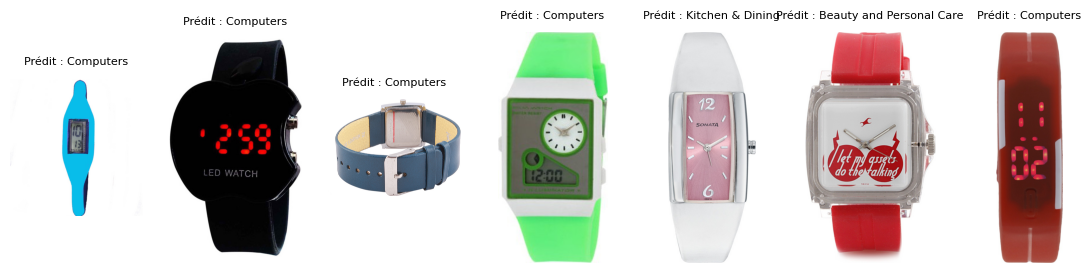

In [68]:
image_path = './images/'
# Affichage des images que VGG16 n'a pas réussi à classer dans la catégorie 'Watches'
plt.figure(figsize=(len(wrong_watches)*2, 3))
for i, image in enumerate(wrong_watches['image'].values):
    filename = image_path + image
    image = imread(filename)
    plt.subplot(1, len(wrong_watches), i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prédit : {wrong_watches.iloc[i]['VGG16 label_name']}", fontsize=8, pad=10)
plt.show()